In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
#### Transformer Encoder

In [2]:
import sys

path_to_utils = '/content/drive/MyDrive/Colab files nyu/pyfiles/'
sys.path.append(path_to_utils)

In [3]:
import global_variables
import nmt_dataset
import nnet_models_new
import math
import time
from tqdm import notebook

In [4]:
# Load data
import os

source_name = 'en'
target_name = 'fr'

base_saved_models_dir = '/content/drive/MyDrive/Colab files nyu/'
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

main_data_path = '/content/drive/MyDrive/Colab files nyu/data/'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [5]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

In [6]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
batchSize = 128

In [7]:
from functools import partial
from torch.utils.data import DataLoader

dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

In [8]:
# Configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words;
target_vocab = dataset_dict['train'].target_lang_obj.n_words;
hidden_size = 512
enc_layers = 1
lr = 0.05;
longest_label = 1;
gradient_clip = 0.3;
use_cuda = True

num_epochs = 20

#### Positional Embeddings

Reference: https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [9]:
import torch
from torch import nn, Tensor

In [10]:
from typing import NamedTuple

class SiTransConfig(NamedTuple):
    """Wrapper object representing architectural hyperparameters."""
    n_vocab: int
    d_model: int
    d_hidden: int
    n_heads: int
    n_layers: int
    seq_len: int
    masked: bool = False
    biases: bool = False  # Add biases to the linear transformations.
    post_ln: bool = False  # Switch to post layer norm.
    scale_scores: bool = False  # Scale the attention weights by a sqrt factor.
    rel_embed: bool = False  # Should we used fixed relative positional embeddings instead of learned ones?
    p_drop: float = 0.  # Dropout probability.

In [11]:
config = SiTransConfig(
    n_vocab=source_vocab,
    d_model=512,
    d_hidden=hidden_size,
    n_heads=2,
    n_layers=enc_layers,
    seq_len=32,
  )

In [12]:
class SiEmbedder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed = nn.Embedding(config.n_vocab, config.d_model)
        self.pos_embed = nn.Embedding(config.seq_len, config.d_model)

        if config.rel_embed:
            # Relative positional embeddings taken from https://arxiv.org/pdf/1706.03762.pdf.
            self.pos_embed.requires_grad = False
            embeddings = self.pos_embed.weight
            for pos in range(config.seq_len):
                for idx in range(config.d_model // 2):
                    embeddings[pos, 2 * idx] = sin(pos / 10000**(2 * idx / config.d_model))
                    embeddings[pos, 2 * idx + 1] = cos(pos / 10000**(2 * idx / config.d_model))

    def forward(self, token_ids):
        _, seq_len = token_ids.size()
        embeddings = self.embed(token_ids)
        positions = torch.arange(seq_len, device=token_ids.device)
        pos_embeddings = self.pos_embed(positions).unsqueeze(dim=0)
        return embeddings + pos_embeddings

In [13]:
class EncoderTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedder = SiEmbedder(config)      # [batch_size, config.seq_len, config.d_model]
        encoder_layer = nn.TransformerEncoderLayer(config.d_model, config.n_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, config.n_layers)
    
    def forward(self, token_ids):
        embeddings = self.embedder(token_ids)
        out = self.encoder(embeddings)
        return out,out.mean(1).unsqueeze(0)

In [ ]:
# Basic RNN decoder (no attention)
decoder_rnn = nnet_models_new.DecoderRNN(target_vocab, hidden_size, enc_layers)
encoder_rnn = EncoderTransformer(config)

nmt_rnn = nnet_models_new.seq2seq(encoder_rnn, decoder_rnn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = enc_layers, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [ ]:
# RNN Decoder with Encoder attention
decoder_rnn_attn = nnet_models_new.Decoder_SelfAttn(target_vocab, hidden_size, self_attention = False, encoder_attention = True)

encoder_rnn_attn = EncoderTransformer(config)

nmt_rnn_attn = nnet_models_new.seq2seq(encoder_rnn_attn, decoder_rnn_attn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = enc_layers, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

#### Training & Evaluation

In [ ]:
def get_full_filepath(path, enc_type):
    filename = '/content/drive/MyDrive/Colab files nyu/nmt_enc_'+enc_type+'_dec_rnn.pth'
    return os.path.join(path, filename)

In [ ]:
def save_models(nmt_model, path, enc_type, loss_cache):
    if not os.path.exists(path):
            os.makedirs(path)
    filename = '/content/drive/MyDrive/Colab files nyu/nmt_enc_'+enc_type+'_dec_rnn.pth'
    torch.save({'loss_cache': loss_cache,
        'model': nmt_model}, os.path.join(path, filename))

In [ ]:
# Train
def train_model(dataloader, nmt, num_epochs=20, val_every=1, saved_model_path = '.', enc_type ='transformer'):
    bleu=[]
    train_loss=[]
    best_bleu = -1;
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, num_epochs));
        
        for i, data in notebook.tqdm(enumerate(dataloader['train']), total=len(dataloader['train'])):  
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train'])
        
        train_loss.append(epoch_loss)
        
        print("epoch {} loss = {}, time = {}".format(epoch+1, epoch_loss,
                                                        time.time() - start))
        sys.stdout.flush()
   
        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            print('validation bleu: ', val_bleu_score)
            bleu.append(val_bleu_score)
            sys.stdout.flush()
            
            nmt.scheduler_step(val_bleu_score);
            
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                save_models(nmt, saved_model_path, enc_type, (bleu,train_loss));

        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))

In [ ]:
train_again = False
if os.path.exists(get_full_filepath(saved_models_dir, 'transformer')) and (not train_again):
    nmt_transformer = torch.load(get_full_filepath(saved_models_dir, 'transformer'), map_location=global_variables.device)
else:
    train_model(dataloader_dict, nmt_rnn_attn, 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      enc_type = 'transformer')

Epoch: [0/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 1 loss = 2.027164416059703, time = 385.15898537635803
validation bleu:  2.2627094614358167
Epoch: [1/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 2 loss = 1.4746842159253286, time = 382.47978591918945
validation bleu:  3.408950706205427
Epoch: [2/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 3 loss = 1.2976327250698212, time = 382.16999435424805
validation bleu:  5.7854627881170755
Epoch: [3/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 4 loss = 1.1522047714405546, time = 382.2103729248047
validation bleu:  8.834092114028662
Epoch: [4/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 5 loss = 1.0206783964388395, time = 381.2378787994385
validation bleu:  11.859723351347627
Epoch: [5/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 6 loss = 0.9041350344618821, time = 382.34652495384216
validation bleu:  14.871882086210945
Epoch: [6/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 7 loss = 0.8160535374353098, time = 381.87996792793274
validation bleu:  16.402752395377274
Epoch: [7/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 8 loss = 0.7387456471143767, time = 380.7279679775238
validation bleu:  18.877245068101985
Epoch: [8/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 9 loss = 0.6760238915978872, time = 380.89611649513245
validation bleu:  20.107560746922587
Epoch: [9/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 10 loss = 0.6281062589003266, time = 380.59942054748535
validation bleu:  21.38610847632727
Epoch: [10/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 11 loss = 0.5848212265559077, time = 380.8998725414276
validation bleu:  22.571237205785238
Epoch: [11/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 12 loss = 0.547373557473602, time = 380.96475648880005
validation bleu:  23.387187460192276
Epoch: [12/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 13 loss = 0.514115640821383, time = 381.4637916088104
validation bleu:  24.190986938798805
Epoch: [13/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 14 loss = 0.4870173098438998, time = 381.09720253944397
validation bleu:  24.229779059908203
Epoch: [14/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 15 loss = 0.4599992019327508, time = 381.5956959724426
validation bleu:  25.518343000821424
Epoch: [15/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 16 loss = 0.4408120576659442, time = 381.23948788642883
validation bleu:  25.922300846535926
Epoch: [16/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 17 loss = 0.4232749207438293, time = 382.09200167655945
validation bleu:  25.725378608786887
Epoch 00017: reducing learning rate of group 0 to 5.0000e-03.
Epoch: [17/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 18 loss = 0.331833415748273, time = 382.36115169525146
validation bleu:  29.273680314376147
Epoch: [18/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 19 loss = 0.2970093507670353, time = 383.36426544189453
validation bleu:  29.98882474327819
Epoch: [19/20]


  0%|          | 0/903 [00:00<?, ?it/s]

epoch 20 loss = 0.2834488815841485, time = 382.95953369140625
validation bleu:  30.172149837015493
Training completed. Best BLEU is 30.172149837015493


---
### 2 Attention visualization (12 pts)

In [15]:
%matplotlib inline

from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# Model was trained in ~2 hours, i.e. you can expect attention maps
# to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [global_variables.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ')+
                       [global_variables.EOS_TOKEN]);

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def get_encoded_batch(sentence, lang_obj, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""
    
    sentence = sentence + ' ' + global_variables.EOS_TOKEN;
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)
    
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
    
    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple( tensor.to(device), 
                                     torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
                                     None,
                                     None,
                                     False );

    return return_tuple

def get_translation(nmt_model, sentence, lang_obj, use_cuda):
    print('souce: ', sentence)
    batch = get_encoded_batch(sentence, lang_obj, use_cuda);
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True);
    prediction = prediction[0];
    print('prediction: ', prediction)
    # print('GT on sentence (src->tgt): ', translator.translate(sentence, 
    #                                                  src = source_name,
    #                                                  dest = target_name).text)
    # print('GT on prediction (tgt->src): ', translator.translate(prediction, 
    #                                                  src = target_name,
    #                                                  dest = source_name).text)
    # print("no. of attn matrices",len(attn_scores_list))
    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list];
            attn_matrix = np.stack(attn_matrix)[:,:, 0]
            showAttention(sentence, prediction, attn_matrix)

#### MODEL 1:
Transformer Encoder with Rnn Decoder (No Attention)

In [14]:
model_dict_1 = torch.load('/content/drive/MyDrive/Colab files nyu/nmt_enc_transformer_dec_rnn_1.pth')

nmt_rnn = model_dict_1['model']

loss_cache_nmt_rnn = model_dict_1['loss_cache']

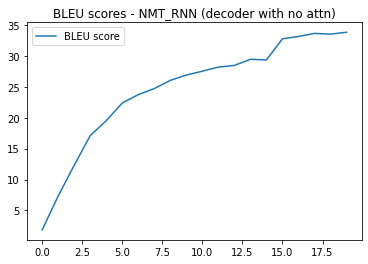

In [26]:
epochs = np.array(list(range(len(loss_cache_nmt_rnn[0]))))
plt.plot(epochs, [i for i in loss_cache_nmt_rnn[0]], label='BLEU score')

plt.legend()
plt.title('BLEU scores - NMT_RNN (decoder with no attn)')
plt.show()

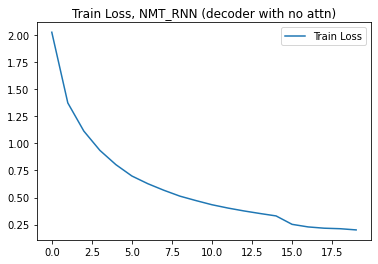

In [27]:
epochs = np.array(list(range(len(loss_cache_nmt_rnn[1]))))
plt.plot(epochs, [i for i in loss_cache_nmt_rnn[1]], label='Train Loss')

plt.legend()
plt.title('Train Loss, NMT_RNN (decoder with no attn)')
plt.show()

In [16]:
sample_1 = next(iter(dataloader_dict['val']))
sentence_1 = dataset_dict['val'].source_lang_obj.vec2txt(sample_1.text_vecs[0].tolist())

In [17]:
get_translation(nmt_rnn, sentence_1, source_lang_obj, use_cuda)

souce:  i don t like sand . it s coarse and rough and irritating and it gets everywhere .
prediction:  je n aime pas le sable . c est grossier rugueux irritant et ca se colle partout .


In [18]:
sample_2 = next(iter(dataloader_dict['val']))
sentence_2 = dataset_dict['val'].source_lang_obj.vec2txt(sample_2.text_vecs[0].tolist())

In [19]:
get_translation(nmt_rnn, sentence_2, source_lang_obj, use_cuda)

souce:  spending time with your significant other should be high on your priority list .
prediction:  passer du temps avec votre bien aime devrait etre en tete de la liste de vos priorites .


In [20]:
sample_3 = next(iter(dataloader_dict['val']))
sentence_3 = dataset_dict['val'].source_lang_obj.vec2txt(sample_3.text_vecs[0].tolist())

In [21]:
get_translation(nmt_rnn, sentence_3, source_lang_obj, use_cuda)

souce:  i d like to ask you a few questions if you don t mind .
prediction:  j aimerais te poser quelques questions si tu n y vois pas d inconvenient .


#### MODEL 2: 
Transformer Encoder, Rnn Decoder with Encoder Attention

In [28]:
model_dict_2 = torch.load('/content/drive/MyDrive/Colab files nyu/nmt_enc_transformer_dec_rnn.pth')

nmt_rnn_attn = model_dict_2['model']

loss_cache_nmt_rnn_attn = model_dict_2['loss_cache']

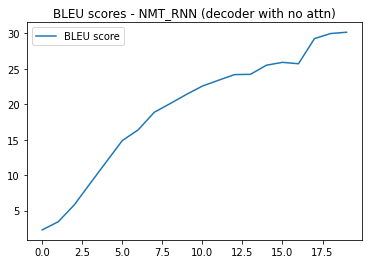

In [29]:
epochs = np.array(list(range(len(loss_cache_nmt_rnn_attn[0]))))
plt.plot(epochs, [i for i in loss_cache_nmt_rnn_attn[0]], label='BLEU score')

plt.legend()
plt.title('BLEU scores - NMT_RNN_ATTN (decoder with encoder attn)')
plt.show()

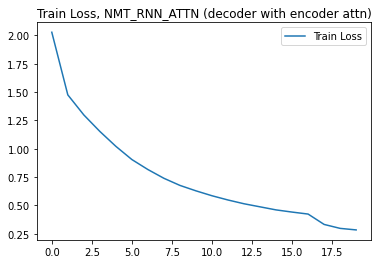

In [30]:
epochs = np.array(list(range(len(loss_cache_nmt_rnn_attn[1]))))
plt.plot(epochs, [i for i in loss_cache_nmt_rnn_attn[1]], label='Train Loss')

plt.legend()
plt.title('Train Loss, NMT_RNN_ATTN (decoder with encoder attn)')
plt.show()

In [ ]:
sample_1 = next(iter(dataloader_dict['val']))
sentence_1 = dataset_dict['val'].source_lang_obj.vec2txt(sample_1.text_vecs[0].tolist())

souce:  according to the contract you may take three days of bereavement leave for your uncle s funeral but only one for your nephew s .
prediction:  selon ton oncle a l exterieur il est preferable de votre cote mais pas d apres trois minutes en retard .


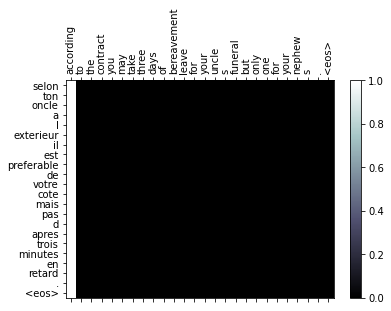

In [ ]:
get_translation(nmt_rnn_attn, sentence_1, source_lang_obj, use_cuda)

In [ ]:
sample_2 = next(iter(dataloader_dict['val']))
sentence_2 = dataset_dict['val'].source_lang_obj.vec2txt(sample_2.text_vecs[0].tolist())

souce:  i won t go with you unless you tell me where we re going .
prediction:  je ne vais pas te sortir avec toi un a l instant .


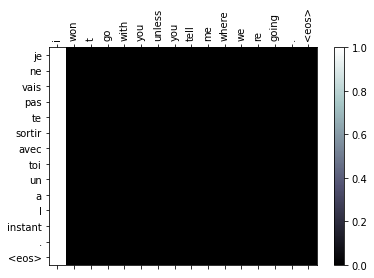

In [ ]:
get_translation(nmt_rnn_attn, sentence_2, source_lang_obj, use_cuda)

In [ ]:
sample_3 = next(iter(dataloader_dict['val']))
sentence_3 = dataset_dict['val'].source_lang_obj.vec2txt(sample_3.text_vecs[0].tolist())

souce:  what is old age ? first you forget names then you forget faces then you forget to pull your zipper up then you forget to pull it down .
prediction:  qu est ce qui vous rappelle de donner a dire que vos vieux aviez les gens de l oublier lorsque vous en aurez les en mesure de vos questions et les femmes


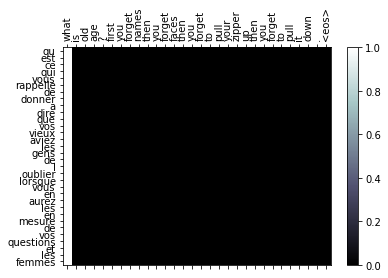

In [ ]:
get_translation(nmt_rnn_attn, sentence_3, source_lang_obj, use_cuda)